In [355]:
%matplotlib inline

In [356]:
from __future__ import print_function, division
import torch
import torchvision
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision.models.resnet import ResNet, BasicBlock
import torchvision.models as models

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].
<div class="alert alert-info"><h4>Note</h4><p>If running on Windows and you get a BrokenPipeError, try setting
    the num_worker of torch.utils.data.DataLoader() to 0.</p></div>



In [357]:
class BanknoteDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform = None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.labels.iloc[idx, -1])
        image = io.imread(img_name)
        image = cv2.resize(image, (256,256), interpolation=cv2.INTER_LINEAR) #rezie image to 128*128
        
        
        #单数label代表的就是one hot encoding部分而不是整个csv文件
        label = self.labels.iloc[idx, :-1]
        label = np.array(label)
        
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)
            
        return sample
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image.astype(np.int)),
                'label': torch.from_numpy(label.astype(np.int))}

In [358]:
def sampleClassSplit(csv_file, train_n, test_n, val_n):
    '''
    Stratified train/test/validation split
    n is percentage of sample like 0.8/0.1/0.1
    '''
    csv = pd.read_csv(csv_file)
    #csv = csv.sample(frac=1).reset_index(drop=True) #shuffle csv
    
    size = len(csv)
    
    train_n = train_n*size/5
    test_n = test_n*size/5
    
    class_counts = {}
    train_data = pd.DataFrame() #empty
    test_data = train_data
    val_data = train_data
    
    
    for i in range(size):
        c = csv.iloc[i,1:]
        c = tuple(c)
        class_counts[c] = class_counts.get(c, 0) + 1
        row = csv.iloc[i]
        if class_counts[c] <= train_n:
            train_data = train_data.append(row,ignore_index = True)
        elif class_counts[c] <= train_n + test_n:
            test_data = test_data.append(row, ignore_index = True)
        else:
            val_data = val_data.append(row, ignore_index = True)
    train_data.to_csv('train_data.csv', index = False)
    test_data.to_csv('test_data.csv', index = False)
    val_data.to_csv('val_data.csv', index = False)

In [359]:
csv_file = "one_hot_labels.csv" 
root_dir = "ThaiCurrencies"

#create splited data csv files
sampleClassSplit(csv_file, 0.8, 0.1, 0.1)

train_data = BanknoteDataset("train_data.csv", root_dir, transform = transforms.Compose([ToTensor()]))
train_data_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=0)

test_data = BanknoteDataset('test_data.csv', root_dir, transform = transforms.Compose([ToTensor()]))
test_data_loader = DataLoader(test_data, batch_size=4, shuffle=True, num_workers=0)

val_data = BanknoteDataset('val_data.csv', root_dir, transform = transforms.Compose([ToTensor()]))
val_loader = DataLoader(val_data, batch_size=4, shuffle=True, num_workers=0)

batch number  0 :  torch.Size([4, 3, 256, 256]) tensor([[1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0]])


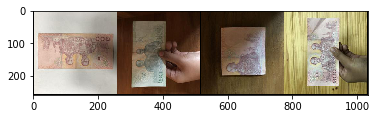

In [360]:
for i_batch, sample_batched in enumerate(train_data_loader):
    print("batch number ",i_batch,": ", 
          sample_batched['image'].size(),
          sample_batched['label'])
    if i_batch == 0:
        images_batch, label_batch = sample_batched['image'], sample_batched['label']
        batch_size = len(images_batch)
        im_size = images_batch.size(2)
        grid = utils.make_grid(images_batch)
        plt.imshow(grid.numpy().transpose((1, 2, 0)))
        break

In [361]:
#这个是不用的
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, 7, padding = 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(96, 128, 5, padding = 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding = 1)
        self.conv4 = nn.Conv2d(256, 128, 3, padding = 1)
        self.fc1 = nn.Linear(128 * 8 * 8, 3000)
        self.fc2 = nn.Linear(3000,1500)
        self.fc3 = nn.Linear(1500, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [362]:
#这个是要用的
net = models.resnet18()

In [365]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#这里learning rate原来是0.001
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [343]:
#传统方法
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_data_loader):
        net = net.float()
        # get the inputs; data is a list of [inputs, labels]
        inputs = data['image'].float()
        labels = data['label'].float()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()  
        if i % 50 == 49:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 49))
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 3.697
[1,   100] loss: 1.860
[1,   150] loss: 1.921
[1,   200] loss: 1.935
[2,    50] loss: 1.783
[2,   100] loss: 2.035
[2,   150] loss: 1.817
[2,   200] loss: 1.782
[3,    50] loss: 1.776
[3,   100] loss: 1.779
[3,   150] loss: 1.714
[3,   200] loss: 1.695
Finished Training


In [366]:
#这个是train和val公用的,每次都把loss放进一个list，最后用来画图

train_loss = []
val_loss = []
for epoch in range(1):
    net.train()
    for i, data in enumerate(train_data_loader):
        inputs = data['image'].float()
        labels = data['label'].float()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        if(i%16==0):
            print('in progress: ', i/160*10, '%')
        
    net.eval()
    for i, data in enumerate(val_loader):
        inputs = data['image'].float()
        labels = data['label'].float()
        outputs = net(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        val_loss.append(loss.item())
        

print('Finished Training')

in progress:  0.0 %


KeyboardInterrupt: 

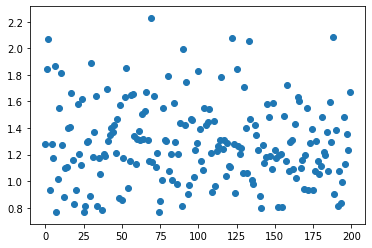

In [352]:
#这画出来的还不如noise
plt.scatter(range(len(train_loss)),train_loss)

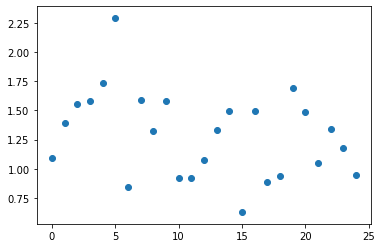

In [353]:
plt.scatter(range(len(val_loss)),val_loss)

In [292]:
PATH= './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [344]:
net = ResNet(BasicBlock, [2, 2, 2, 2], num_classes = 5)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [354]:
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
with torch.no_grad():
    for i, data in enumerate(test_data_loader):
        images = data['image'].float()
        label = data['label'].float()
        outputs = net(images)
        
        #print(torch.max(outputs, 1)[1])
        #print(torch.max(label, 1)[1])
        
        cat_outputs = torch.max(outputs, 1)[1]
        cat_label = torch.max(label, 1)[1]
        c = (cat_outputs == cat_label).squeeze()
        for i in range(4):
            lab = cat_label[i]
            if(c[i]):
                class_correct[lab] += 1
            class_total[lab] += 1
print(class_correct)
print(class_total)
for i in range(5):
    print('Accuracy class %2d: %2d %%' % (i,100 * class_correct[i] / class_total[i]))

[8.0, 5.0, 14.0, 13.0, 0.0]
[20.0, 20.0, 20.0, 20.0, 20.0]
Accuracy class  0: 40 %
Accuracy class  1: 25 %
Accuracy class  2: 70 %
Accuracy class  3: 65 %
Accuracy class  4:  0 %


Training on GPU
----------------

In [235]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


The rest of this section assumes that ``device`` is a CUDA device.

Then these methods will recursively go over all modules and convert their
parameters and buffers to CUDA tensors:

.. code:: python

    net.to(device)


Remember that you will have to send the inputs and targets at every step
to the GPU too:

.. code:: python

        inputs, labels = data[0].to(device), data[1].to(device)

Why dont I notice MASSIVE speedup compared to CPU? Because your network
is really small.

**Exercise:** Try increasing the width of your network (argument 2 of
the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
they need to be the same number), see what kind of speedup you get.

**Goals achieved**:

- Understanding PyTorch's Tensor library and neural networks at a high level.
- Train a small neural network to classify images

Training on multiple GPUs
-------------------------
If you want to see even more MASSIVE speedup using all of your GPUs,
please check out :doc:`data_parallel_tutorial`.

Where do I go next?
-------------------

-  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
-  `Train a state-of-the-art ResNet network on imagenet`_
-  `Train a face generator using Generative Adversarial Networks`_
-  `Train a word-level language model using Recurrent LSTM networks`_
-  `More examples`_
-  `More tutorials`_
-  `Discuss PyTorch on the Forums`_
-  `Chat with other users on Slack`_


